# DATA 1030 Fall 2025 Final Project
## Predicting Global Video Game Sales
Cecily Chung, Brown University

cecily_chung@brown.edu

The purpose of this project is to build a full machine learning pipeline to predict global video game sales based on the features of the video game. This project was done for Brown University's DATA1030 final project.

This pipeline uses 2 datasets found from Kaggle. Resources and a full report of the work done can be found in the `report/` directory.

### Loading in Data

In [2]:
import pandas as pd
import numpy as np

# loading in dfs and printing for visualization purposes
sales_df = pd.read_csv("../data/vgsales.csv")
critic_df = pd.read_csv("../data/games-data.csv")

print("SALES DF:")
print(sales_df.head())

print("SALES COLUMNS:")
print(sales_df.columns)

print("CRITIC DF:")
print(critic_df.head())

print("CRITIC COLUMNS")
print(critic_df.columns)

SALES DF:
   Rank                      Name Platform    Year         Genre Publisher  \
0     1                Wii Sports      Wii  2006.0        Sports  Nintendo   
1     2         Super Mario Bros.      NES  1985.0      Platform  Nintendo   
2     3            Mario Kart Wii      Wii  2008.0        Racing  Nintendo   
3     4         Wii Sports Resort      Wii  2009.0        Sports  Nintendo   
4     5  Pokemon Red/Pokemon Blue       GB  1996.0  Role-Playing  Nintendo   

   NA_Sales  EU_Sales  JP_Sales  Other_Sales  Global_Sales  
0     41.49     29.02      3.77         8.46         82.74  
1     29.08      3.58      6.81         0.77         40.24  
2     15.85     12.88      3.79         3.31         35.82  
3     15.75     11.01      3.28         2.96         33.00  
4     11.27      8.89     10.22         1.00         31.37  
SALES COLUMNS:
Index(['Rank', 'Name', 'Platform', 'Year', 'Genre', 'Publisher', 'NA_Sales',
       'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales'],


### Data Cleaning

In [3]:
# CLEANING SALES_DF

# dropping the columns for the following reasons:
# Rank: games on the same platform later get aggregated but also Rank is very dependent on other 
# games at the time, making it a somewhat unhelpful parameter for ML
# Sales: All dropped as they interfere with predicting the target variable (global_sales)
sales_clean = sales_df.drop(['Rank', 'NA_Sales', 'JP_Sales', 'EU_Sales', 'Other_Sales'], axis=1)

sales_clean.columns = sales_clean.columns.str.lower()

print("BEFORE CLEANING:")
print(sales_clean.columns)
print(sales_clean.head())

# visualizing missing values
missing_sales = sales_clean.isnull().sum()
print("VALUES MISSING: ")
print(missing_sales)

# standardizing the titles of video games in preparation for merging with the other df
sales_clean['name'] = sales_clean['name'].str.strip().str.lower()

sales_clean['publisher'] = sales_clean['publisher'].str.strip().str.lower()

# creating a column marking the earliest year of release
sales_first_release = sales_clean.groupby('name')['year'].min().reset_index(name='first_release')
sales_clean = sales_clean.merge(sales_first_release, on='name')

# drop all instances of the game that were released after 1 year of initial release
# this avoids bias towards extra ports of the game 
# if a year is NaN, keep it and aggregate it if there is another match
# ex: Minecraft on WiiU will probably do well because Minecraft on Xbox did well. This doesn't mean
# games on WiiU necessarily do better and shouldn't be used in the model.
sales_clean = sales_clean[sales_clean['year'].isna() | (sales_clean['year'] <= sales_clean['first_release'] + 1)]

# aggregate all instances of a game now that you only have initial releases  
sales_clean = sales_clean.groupby('name', as_index=False, sort=False).agg({
    'platform': set, 
    'year': 'min', 
    'genre': set, 
    'publisher': lambda s: (
        {x for x in s if isinstance(x, str)} 
        or np.nan
    ),
    'global_sales': 'sum'})

print("AFTER CLEANING:")
print(sales_clean.head())

missing_sales = sales_clean.isnull().sum()
print("VALUES MISSING: ")
print(missing_sales)

BEFORE CLEANING:
Index(['name', 'platform', 'year', 'genre', 'publisher', 'global_sales'], dtype='object')
                       name platform    year         genre publisher  \
0                Wii Sports      Wii  2006.0        Sports  Nintendo   
1         Super Mario Bros.      NES  1985.0      Platform  Nintendo   
2            Mario Kart Wii      Wii  2008.0        Racing  Nintendo   
3         Wii Sports Resort      Wii  2009.0        Sports  Nintendo   
4  Pokemon Red/Pokemon Blue       GB  1996.0  Role-Playing  Nintendo   

   global_sales  
0         82.74  
1         40.24  
2         35.82  
3         33.00  
4         31.37  
VALUES MISSING: 
name              0
platform          0
year            271
genre             0
publisher        58
global_sales      0
dtype: int64
AFTER CLEANING:
                       name platform    year           genre   publisher  \
0                wii sports    {Wii}  2006.0        {Sports}  {nintendo}   
1         super mario bros.    {NE

In [4]:
# CLEANING CRITICS DF

critics_clean = critic_df.copy()

missing = critics_clean.isnull().sum()
print("VALUES MISSING: ")
print(missing)

# converting column names to lowercase and changing spaces to _
critics_clean.columns = critics_clean.columns.str.lower()
critics_clean.columns = (
    critics_clean.columns.str.strip().str.lower().str.replace(' ', '_')
)

# cleaning up the players column into 4 categories: unknown, single, two, multi
critics_clean['players'] = critics_clean['players'].apply(
    lambda x: (
        "unknown" if pd.isna(x) or str(x).strip() == "No info"
        else "single" if str(x).strip() in {"1 Player", "No Online Multiplayer"}
        else "two" if str(x).strip() in {"1-2", "2", "2  Online"}
        else "multi"
    )
)

# cleaning platform column to match the other dataset
critics_clean['platform'] = critics_clean['platform'].apply(
    lambda x: (
        "DC" if str(x) == "Dreamcast"
        else "GBA" if str(x) == "GameBoyAdvance"
        else "GC" if str(x) == "GameCube"
        else "N64" if str(x) == "Nintendo64"
        else "PS" if str(x) == "PlayStation"
        else "PS2" if str(x) == "PlayStation2"
        else "PS3" if str(x) == "PlayStation3"
        else "PS4" if str(x) == "PlayStation4"
        else "PSV" if str(x) == "PlayStationVita"
        else "XB" if str(x) == "Xbox"
        else "X360" if str(x) == "Xbox360"
        else "XOne" if str(x) == "XboxOne"
        else str(x)
    )
)

# convert the release date to a release year
# although date would be helpful informaiton, we need to aggregate platform releases anyway
critics_clean['year'] = pd.to_datetime(critics_clean['r-date'], format='%B %d, %Y').dt.year
critics_clean = critics_clean.drop(['r-date'], axis=1)

print(critics_clean.columns)
print(critics_clean.head())

# standardizing the titles of video games in preparation for merging with the other df
critics_clean['name'] = critics_clean['name'].str.strip().str.lower()

# creating a column marking the earliest year of release
critics_first_release = critics_clean.groupby('name')['year'].min().reset_index(name='first_release')
critics_clean = critics_clean.merge(critics_first_release, on='name')

# drop all instances of the game that were released after 1 year of initial release
critics_clean = critics_clean[critics_clean['year'] <= critics_clean['first_release'] + 1]

# change 'tbd' values to NaN
critics_clean['user_score'] = critics_clean['user_score'].astype(str).str.strip().replace({'tbd': np.nan})
critics_clean['user_score'] = pd.to_numeric(critics_clean['user_score'])

# aggregate all instances of a game now that you only have initial releases  
critics_clean = critics_clean.groupby('name', as_index=False, sort=False).agg({
    'platform': set, 
    'year': 'min', 
    'developer': lambda s: {
        val
        for devs in s
        for val in devs.split(',')
    },
    'genre': lambda s: {
        val
        for genres in s
        for val in genres.split(',')
    },
    'players': 'first',
    'score': 'mean', 
    'user_score': 'mean', 
    'critics': 'mean', 
    'users': 'mean'})

print(critics_clean.head())

missing = critics_clean.isnull().sum()
print("VALUES MISSING: ")
print(missing)

VALUES MISSING: 
name           0
platform       0
r-date         0
score          0
user score     0
developer      0
genre          0
players       22
critics        0
users          0
dtype: int64
Index(['name', 'platform', 'score', 'user_score', 'developer', 'genre',
       'players', 'critics', 'users', 'year'],
      dtype='object')
                                   name platform  score user_score  \
0  The Legend of Zelda: Ocarina of Time      N64     99        9.1   
1              Tony Hawk's Pro Skater 2       PS     98        7.4   
2                   Grand Theft Auto IV      PS3     98        7.6   
3                           SoulCalibur       DC     98        8.5   
4                   Grand Theft Auto IV     X360     98        7.9   

                developer                                      genre players  \
0                Nintendo                   Action Adventure,Fantasy  single   
1  NeversoftEntertainment           Sports,Alternative,Skateboarding     two  

In [5]:
# MERGING DATASETS

vg_df = sales_clean.merge(critics_clean, how='left', on='name')

print(vg_df.columns)

# the code operates on the basis that the left-hand dataset is filled out for these cols
if pd.isna(vg_df['platform_x']).any():
    raise ValueError("Found missing values in platform_x.")

if pd.isna(vg_df['genre_x']).any():
    raise ValueError("Found missing values in genre_x.")

# creating a column that indicates which of x or y we should choose
# if the datasets have entries from within a year of each other, they are considered "equal" and data should be merged
# if one dataset is earlier than the other, use the data from that one
vg_df['year_choice'] = vg_df.apply(
    lambda row: (
        'x' if (pd.isna(row['year_y']) or pd.isna(row['year_x']))
        else 'equal' if abs(row['year_x'] - row['year_y']) <= 1
        else 'x'
    ),
    axis=1
)

# combining platforms
vg_df['platform'] = vg_df.apply(
    lambda row: (
        row['platform_x'] | row['platform_y'] if row['year_choice'] == 'equal'
        else row['platform_x']
    ),
    axis=1
)
vg_df.drop(['platform_x', 'platform_y'], axis=1, inplace=True)

# combining genres: ignore Misc if there's another option
vg_df['genre'] = vg_df.apply(
    lambda row: (
        (set() if 'Misc' in row['genre_x'] else row['genre_x']) | row['genre_y'] if row['year_choice'] == 'equal'
        else row['genre_x']
    ),
    axis=1
)
vg_df.drop(['genre_x', 'genre_y'], axis=1, inplace=True)

# combine years, take the minimum if they were considered equal
vg_df['year'] = vg_df.apply(
    lambda row: (
        row[['year_x', 'year_y']].min() if row['year_choice'] == 'equal'
        else row['year_x']
    ), 
    axis=1
).astype('Int64')

# some titles share the same name but are from different years.
# like the above, set these cols to NaN if the sales df has an earlier version
cols_from_critic = ['developer', 'score', 'user_score', 'players', 'users', 'critics'] 
vg_df.loc[vg_df['year_choice'] == 'x', cols_from_critic] = np.nan

vg_df.drop(['year_x', 'year_y', 'year_choice'], axis=1, inplace=True)

print(vg_df.columns)

print("TOTAL VALUES:")
print(vg_df['name'].nunique())

print(vg_df.head())
print(len(vg_df))

Index(['name', 'platform_x', 'year_x', 'genre_x', 'publisher', 'global_sales',
       'platform_y', 'year_y', 'developer', 'genre_y', 'players', 'score',
       'user_score', 'critics', 'users'],
      dtype='object')
Index(['name', 'publisher', 'global_sales', 'developer', 'players', 'score',
       'user_score', 'critics', 'users', 'platform', 'genre', 'year'],
      dtype='object')
TOTAL VALUES:
11493
                       name   publisher  global_sales   developer players  \
0                wii sports  {nintendo}         82.74  {Nintendo}  single   
1         super mario bros.  {nintendo}         40.24         NaN     NaN   
2            mario kart wii  {nintendo}         35.82  {Nintendo}   multi   
3         wii sports resort  {nintendo}         33.00  {Nintendo}   multi   
4  pokemon red/pokemon blue  {nintendo}         31.37         NaN     NaN   

   score  user_score  critics  users platform  \
0   76.0         8.0     51.0  429.0    {Wii}   
1    NaN         NaN      NaN  

### EDA

In [6]:
# PERFORMING EDA

print("ROWS, COLUMNS:", vg_df.shape)
print(vg_df.columns)
print(vg_df.head())

print("COLUMN TYPES: ", vg_df.dtypes)

ROWS, COLUMNS: (11493, 12)
Index(['name', 'publisher', 'global_sales', 'developer', 'players', 'score',
       'user_score', 'critics', 'users', 'platform', 'genre', 'year'],
      dtype='object')
                       name   publisher  global_sales   developer players  \
0                wii sports  {nintendo}         82.74  {Nintendo}  single   
1         super mario bros.  {nintendo}         40.24         NaN     NaN   
2            mario kart wii  {nintendo}         35.82  {Nintendo}   multi   
3         wii sports resort  {nintendo}         33.00  {Nintendo}   multi   
4  pokemon red/pokemon blue  {nintendo}         31.37         NaN     NaN   

   score  user_score  critics  users platform  \
0   76.0         8.0     51.0  429.0    {Wii}   
1    NaN         NaN      NaN    NaN    {NES}   
2   82.0         8.4     73.0  982.0    {Wii}   
3   80.0         8.1     73.0  266.0    {Wii}   
4    NaN         NaN      NaN    NaN     {GB}   

                                         genr

In [7]:
# duplicates check
hashable_cols = ['name', 'global_sales', 'players', 'score', 'user_score', 'critics', 'users', 'year']
duplicates = vg_df[hashable_cols].duplicated()
if (duplicates.any()):
    print("DUPLICATES FOUND.")
    vg_df = vg_df.drop_duplicates(subset=hashable_cols, keep='first')
else:
    print("No duplicates.")

No duplicates.


In [8]:

# general value and type checks for each column
if (pd.isna(vg_df['global_sales']).any()):
    raise ValueError("Missing global sales figure for some games.")
      
if not (vg_df['name'].apply(lambda x: isinstance(x, str)).all()):
    raise ValueError("Invalid names.")

if not (vg_df['developer'].apply(lambda s: True if pd.isna(s) else all(isinstance(x, str) for x in s)).all()):
    raise ValueError("Invalid developer names.")

if not (vg_df['publisher'].apply(lambda s: True if pd.isna(s) else all(isinstance(x, str) for x in s)).all()):
    raise ValueError("Invalid publisher names.")

if not (vg_df['players'].apply(lambda x: True if pd.isna(x) else isinstance(x, str) and x in ['unknown', 'single', 'two', 'multi']).all()):
    raise ValueError("Invalid player values.")

if not (vg_df['score'].apply(lambda x: True if pd.isna(x) else isinstance(x, float) and x >= 0 and x <= 100).all()):
    raise ValueError("Invalid score.")

if not (vg_df['user_score'].apply(lambda x: True if pd.isna(x) else isinstance(x, float) and x >= 0 and x <= 10).all()):
    raise ValueError("Invalid user score.")

if not (vg_df['critics'].apply(lambda x: True if pd.isna(x) else isinstance(x, float) and x >= 0).all()):
    raise ValueError("Invalid number of critics.")

if not (vg_df['score'].apply(lambda x: True if pd.isna(x) else isinstance(x, float) and x >= 0).all()):
    raise ValueError("Invalid score.")

if not (vg_df['platform'].apply(lambda s: True if pd.isna(s) else all(isinstance(x, str) for x in s)).all()):
    raise ValueError("Invalid platform names.")

if not (vg_df['year'].apply(lambda x: True if pd.isna(x) else (isinstance(x, float) and x >= 0 and x <= 2025)).all()):
    raise ValueError("Invalid year.")


In [9]:
# checking for missing values
missing = vg_df.isnull().sum()
percent_missing = missing.sum() / vg_df.size
print("NUMBER MISSING: " + str(missing.sum()))
print("PERCENT MISSING: " + str(percent_missing.sum()))
print("VALUES MISSING: ")
print(missing)

NUMBER MISSING: 42366
PERCENT MISSING: 0.30718698338118855
VALUES MISSING: 
name               0
publisher         51
global_sales       0
developer       6983
players         6983
score           6983
user_score      7267
critics         6983
users           6983
platform           0
genre              0
year             133
dtype: int64


In [10]:
# use .describe() because the value is continuous
print(vg_df["global_sales"].describe())

count    11493.000000
mean         0.757921
std          2.192498
min          0.010000
25%          0.060000
50%          0.190000
75%          0.600000
max         82.740000
Name: global_sales, dtype: float64


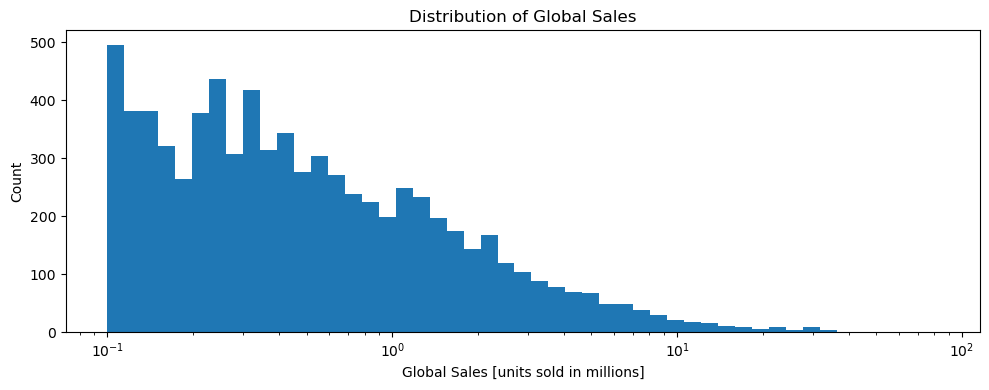

Graph displaying distribution of global sales of copies of the game.


In [11]:
from matplotlib import pylab as plt

# visualizing the target variable, global_sales
plt.figure(figsize=(10, 4))

vg_df['global_sales'].plot.hist(bins = np.logspace(np.log10(0.1), np.log10(np.max(vg_df['global_sales'])), 50))
plt.semilogx()
plt.xlabel('Global Sales [units sold in millions]')
plt.ylabel('Count')
plt.title("Distribution of Global Sales")
plt.tight_layout()
plt.savefig("../figures/distribution_global_sales.png", dpi=300, bbox_inches="tight")
plt.show()

print("Graph displaying distribution of global sales of copies of the game.")

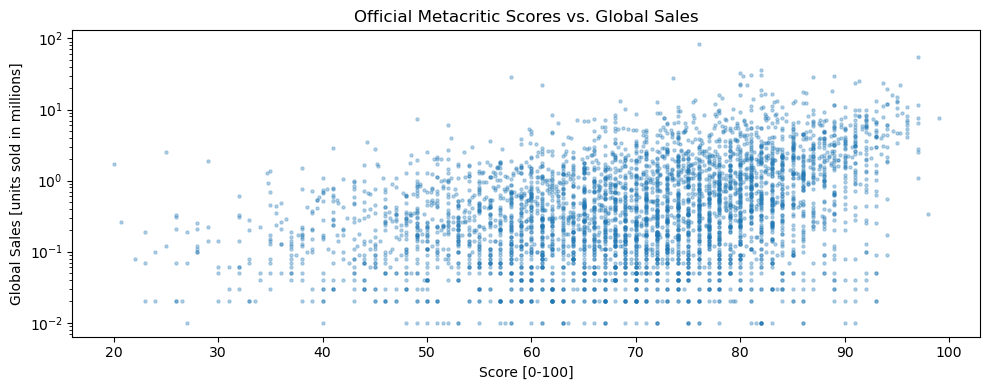

Graph displaying correlation between official Metacritic scores (0-100) vs. number of copies sold globally.
As you can see, there is a strong positive correlation.


In [12]:
vg_df.plot.scatter('score', 'global_sales',figsize=(10, 4),alpha=0.3,s=5)
plt.semilogy()
plt.ylabel("Global Sales [units sold in millions]")
plt.xlabel("Score [0-100]")
plt.title("Official Metacritic Scores vs. Global Sales")
plt.tight_layout()
plt.savefig("../figures/metacritic_sales.png", dpi=300, bbox_inches="tight")
plt.show()

print("Graph displaying correlation between official Metacritic scores (0-100) vs. number of copies sold globally.")
print("As you can see, there is a strong positive correlation.")

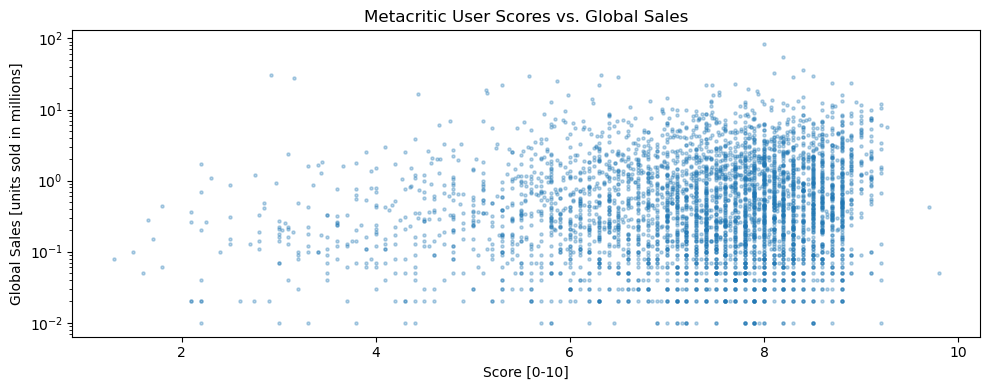

Graph displaying correlation between Metacritic's user scores (0-10) vs. number of copies sold globally.
There is still a positive correlation, but not as strong as with the official Metacritic scores.


In [13]:
vg_df.plot.scatter('user_score', 'global_sales',figsize=(10, 4),alpha=0.3,s=5)
plt.semilogy()
plt.ylabel("Global Sales [units sold in millions]")
plt.xlabel("Score [0-10]")
plt.title("Metacritic User Scores vs. Global Sales")
plt.tight_layout()
plt.savefig("../figures/userscores_sales.png", dpi=300, bbox_inches="tight")
plt.show()

print("Graph displaying correlation between Metacritic's user scores (0-10) vs. number of copies sold globally.")
print("There is still a positive correlation, but not as strong as with the official Metacritic scores.")

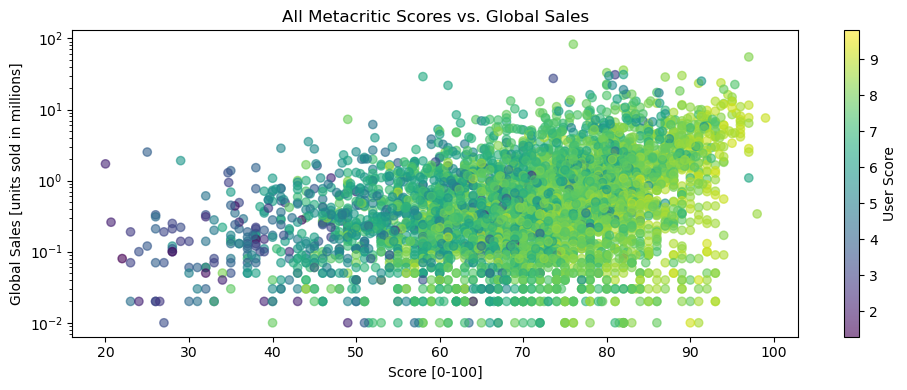

Graph displaying relationship between official Metacritic scores and Metacritic's user scores vs. number of copies sold globally.
There is some discrepancy with occasional games performing badly with users but selling well.
There is still a general positive correlation, and games that do well on Metacritic tend to do well with users.


In [14]:
plt.figure(figsize=(10, 4))

plt.scatter(
    vg_df['score'],
    vg_df['global_sales'],
    c=vg_df['user_score'], cmap='viridis', alpha=0.6
)
plt.colorbar(label='User Score')
plt.semilogy()
plt.ylabel("Global Sales [units sold in millions]")
plt.xlabel("Score [0-100]")
plt.title("All Metacritic Scores vs. Global Sales")
plt.tight_layout()
plt.savefig("../figures/metacritic_user_sales.png", dpi=300, bbox_inches="tight")
plt.show()

print("Graph displaying relationship between official Metacritic scores and Metacritic's user scores vs. number of copies sold globally.")
print("There is some discrepancy with occasional games performing badly with users but selling well.")
print("There is still a general positive correlation, and games that do well on Metacritic tend to do well with users.")

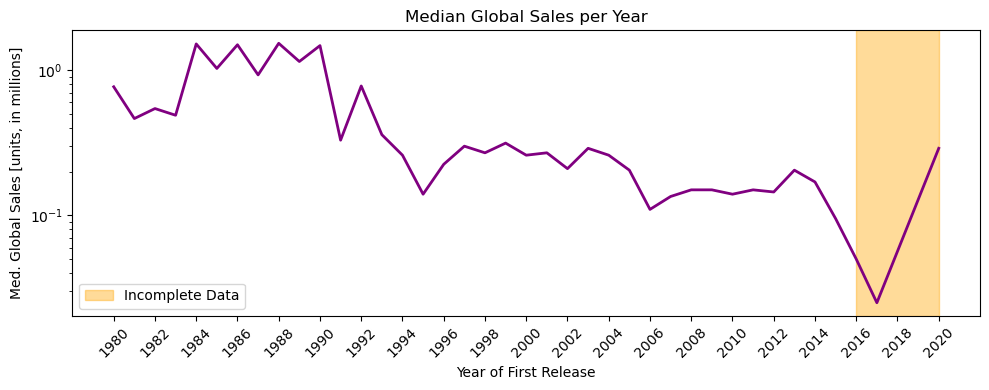

Graph displaying median global sales over the years. There is a general downward trend.
The area in orange is marked as such as there is very little data for 2017 and 2020.


In [15]:
yearly = vg_df.groupby('year')['global_sales'].median().reset_index()

plt.figure(figsize=(10,4))
plt.plot(yearly['year'], yearly['global_sales'], color='purple', linewidth=2)
plt.semilogy()
plt.xticks(np.arange(1980, 2021, 2))
plt.xticks(rotation=45)
plt.axvspan(2016, 2020, color='orange', alpha=0.4, label='Incomplete Data')
plt.legend()
plt.xlabel('Year of First Release')
plt.ylabel('Med. Global Sales [units, in millions]')
plt.title('Median Global Sales per Year')
plt.tight_layout()
plt.savefig("../figures/median_sales_year.png", dpi=300, bbox_inches="tight")
plt.show()

print("Graph displaying median global sales over the years. There is a general downward trend.")
print("The area in orange is marked as such as there is very little data for 2017 and 2020.")

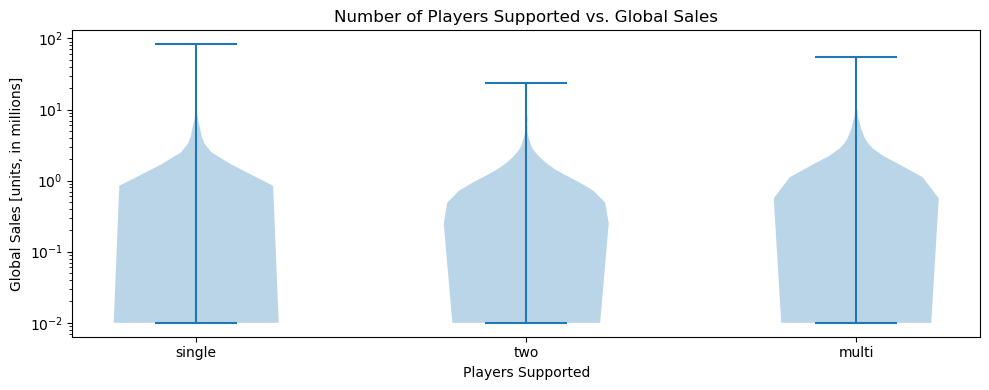

Graph displaying relationship between number of players a game supports vs. global sales.
There is perhaps a slight positive trend for multiplayer games, but overall not a strong correlation.


In [16]:
dataset = [vg_df[vg_df['players'] == 'single']['global_sales'].values,
           vg_df[vg_df['players'] == 'two']['global_sales'].values,
           vg_df[vg_df['players'] == 'multi']['global_sales'].values]

plt.figure(figsize=(10,4))

plt.violinplot(dataset = dataset)
plt.semilogy()
plt.xticks([1, 2, 3],['single', 'two', 'multi'])
plt.xlabel("Players Supported")
plt.ylabel('Global Sales [units, in millions]')
plt.title("Number of Players Supported vs. Global Sales")
plt.tight_layout()
plt.savefig("../figures/players_sales.png", dpi=300, bbox_inches="tight")
plt.show()

print("Graph displaying relationship between number of players a game supports vs. global sales.")
print("There is perhaps a slight positive trend for multiplayer games, but overall not a strong correlation.")

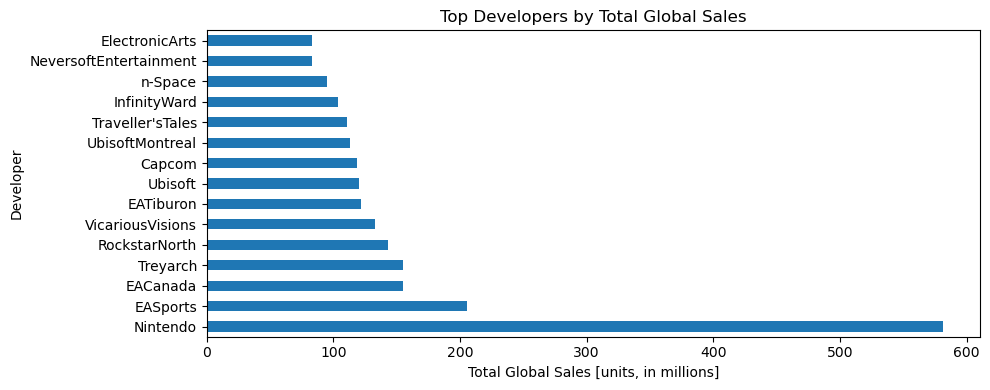

Graph displaying the top 15 developers by their TOTAL global sales.


In [17]:
vg_df_exploded = vg_df.explode('developer').copy()
top_dev_sales = vg_df_exploded.groupby('developer')['global_sales'].sum().sort_values(ascending=False).head(15)

plt.figure(figsize=(10, 4))
top_dev_sales.plot.barh()
plt.xlabel('Total Global Sales [units, in millions]')
plt.ylabel('Developer')
plt.title('Top Developers by Total Global Sales')
plt.tight_layout()
plt.savefig("../figures/developers_sales_total.png", dpi=300, bbox_inches="tight")
plt.show()

print("Graph displaying the top 15 developers by their TOTAL global sales.")

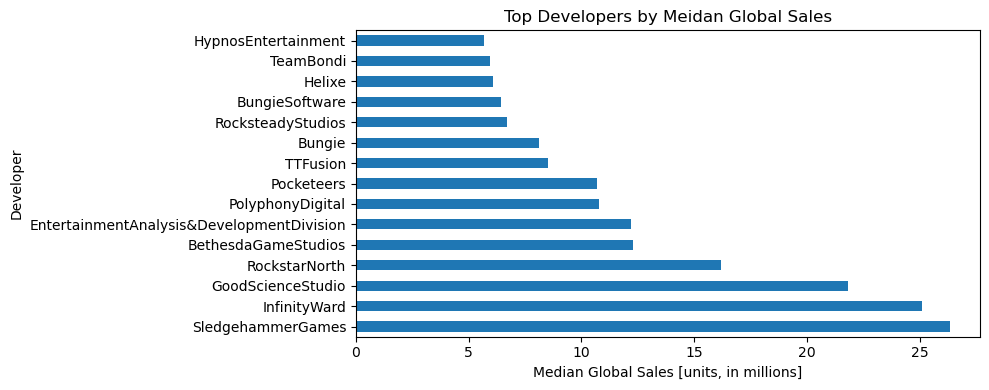

Graph displaying the top 15 developers by their MEDIAN global sales.


In [18]:
vg_df_exploded = vg_df.explode('developer').copy()
top_dev_sales = vg_df_exploded.groupby('developer')['global_sales'].median().sort_values(ascending=False).head(15)

plt.figure(figsize=(10, 4))
top_dev_sales.plot.barh()
plt.xlabel('Median Global Sales [units, in millions]')
plt.ylabel('Developer')
plt.title('Top Developers by Meidan Global Sales')
plt.tight_layout()
plt.savefig("../figures/developers_sales_median.png", dpi=300, bbox_inches="tight")
plt.show()

print("Graph displaying the top 15 developers by their MEDIAN global sales.")

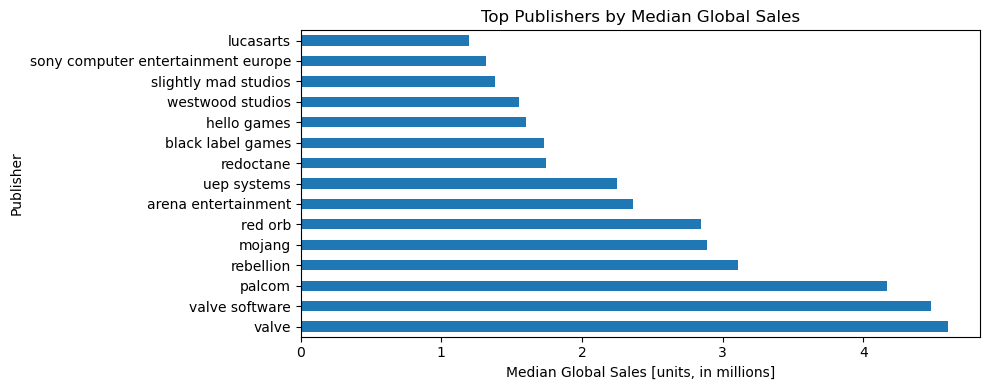

Graph displaying the top 15 publishers by their median global sales.


In [19]:
vg_df_exploded = vg_df.explode('publisher').copy()
top_dev_sales = vg_df_exploded.groupby('publisher')['global_sales'].median().sort_values(ascending=False).head(15)

plt.figure(figsize=(10, 4))
top_dev_sales.plot.barh()
plt.xlabel('Median Global Sales [units, in millions]')
plt.ylabel('Publisher')
plt.title('Top Publishers by Median Global Sales')
plt.tight_layout()
plt.savefig("../figures/publishers_sales_median.png", dpi=300, bbox_inches="tight")
plt.show()

print("Graph displaying the top 15 publishers by their median global sales.")

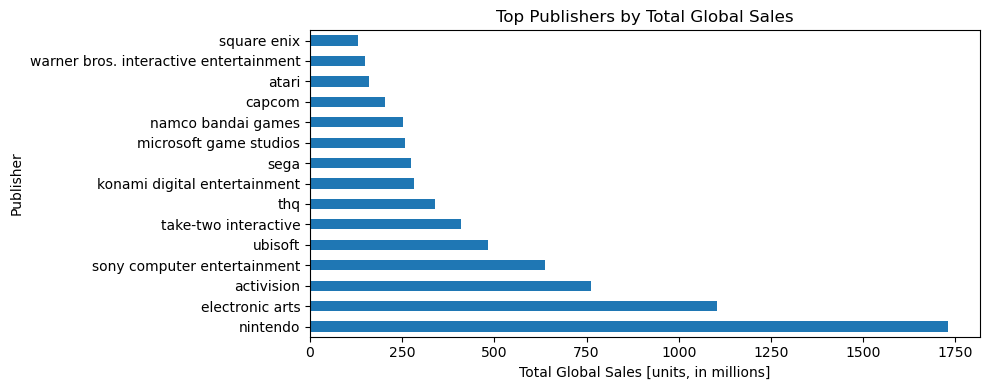

Graph displaying the top 15 publishers by their total global sales.


In [20]:
vg_df_exploded = vg_df.explode('publisher').copy()
top_dev_sales = vg_df_exploded.groupby('publisher')['global_sales'].sum().sort_values(ascending=False).head(15)

plt.figure(figsize=(10, 4))
top_dev_sales.plot.barh()
plt.xlabel('Total Global Sales [units, in millions]')
plt.ylabel('Publisher')
plt.title('Top Publishers by Total Global Sales')
plt.tight_layout()
plt.savefig("../figures/publishers_sales_total.png", dpi=300, bbox_inches="tight")
plt.show()

print("Graph displaying the top 15 publishers by their total global sales.")

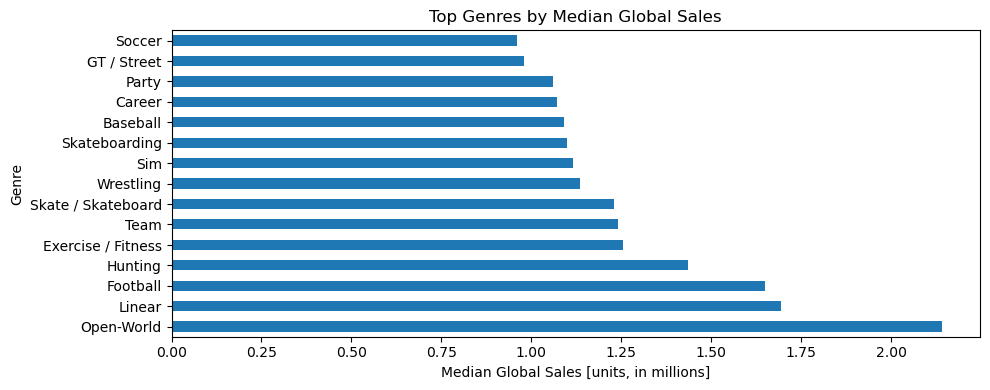

Graph displaying the top 15 game genres by their median global sales.


In [21]:
vg_df_exploded = vg_df.explode('genre').copy()
top_dev_sales = vg_df_exploded.groupby('genre')['global_sales'].median().sort_values(ascending=False).head(15)

plt.figure(figsize=(10, 4))
top_dev_sales.plot.barh()
plt.xlabel('Median Global Sales [units, in millions]')
plt.ylabel('Genre')
plt.title('Top Genres by Median Global Sales')
plt.tight_layout()
plt.savefig("../figures/genres_sales_median.png", dpi=300, bbox_inches="tight")
plt.show()

print("Graph displaying the top 15 game genres by their median global sales.")

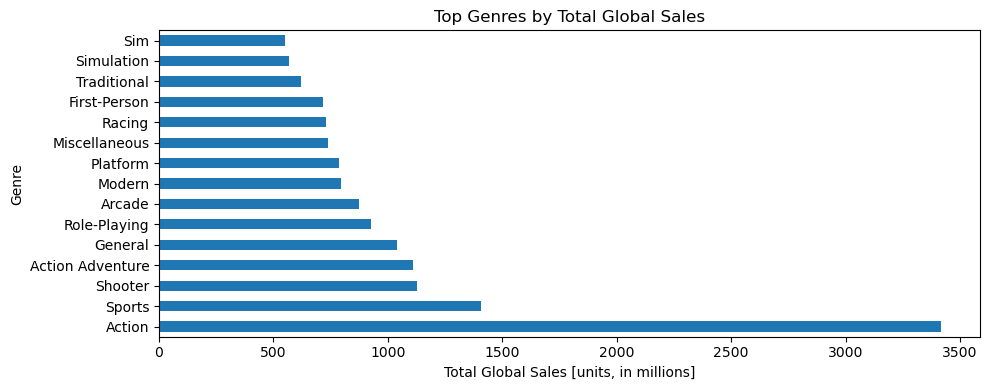

Graph displaying the top 15 game genres by their total global sales.


In [22]:
vg_df_exploded = vg_df.explode('genre').copy()
top_dev_sales = vg_df_exploded.groupby('genre')['global_sales'].sum().sort_values(ascending=False).head(15)

plt.figure(figsize=(10, 4))
top_dev_sales.plot.barh()
plt.xlabel('Total Global Sales [units, in millions]')
plt.ylabel('Genre')
plt.title('Top Genres by Total Global Sales')
plt.tight_layout()
plt.savefig("../figures/genres_sales_total.png", dpi=300, bbox_inches="tight")
plt.show()

print("Graph displaying the top 15 game genres by their total global sales.")

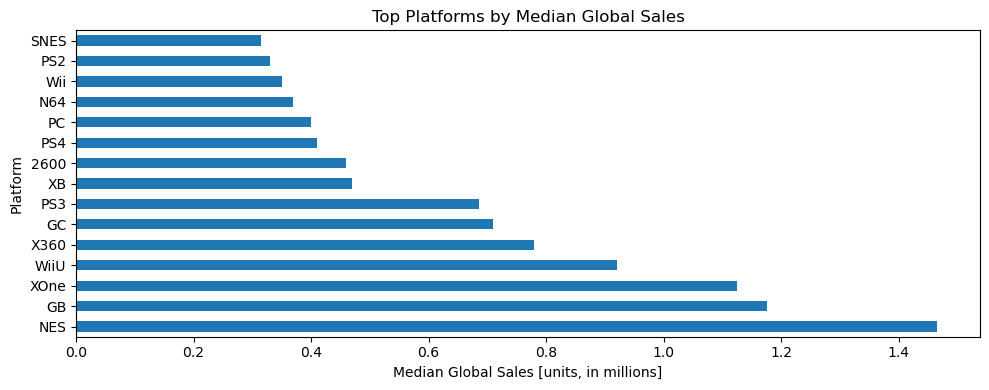

Graph displaying the top 15 gaming platforms by their median global sales.


In [23]:
vg_df_exploded = vg_df.explode('platform').copy()
top_dev_sales = vg_df_exploded.groupby('platform')['global_sales'].median().sort_values(ascending=False).head(15)

plt.figure(figsize=(10, 4))
top_dev_sales.plot.barh()
plt.xlabel('Median Global Sales [units, in millions]')
plt.ylabel('Platform')
plt.title('Top Platforms by Median Global Sales')
plt.tight_layout()
plt.savefig("../figures/platforms_sales_median.png", dpi=300, bbox_inches="tight")
plt.show()

print("Graph displaying the top 15 gaming platforms by their median global sales.")

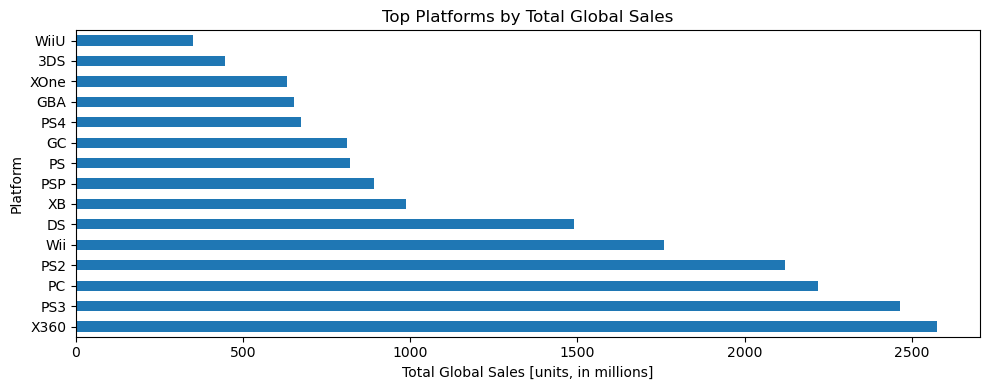

Graph displaying the top 15 gaming platforms by their total global sales.


In [24]:
vg_df_exploded = vg_df.explode('platform').copy()
top_dev_sales = vg_df_exploded.groupby('platform')['global_sales'].sum().sort_values(ascending=False).head(15)

plt.figure(figsize=(10, 4))
top_dev_sales.plot.barh()
plt.xlabel('Total Global Sales [units, in millions]')
plt.ylabel('Platform')
plt.title('Top Platforms by Total Global Sales')
plt.tight_layout()
plt.savefig("../figures/platforms_sales_total.png", dpi=300, bbox_inches="tight")
plt.show()

print("Graph displaying the top 15 gaming platforms by their total global sales.")

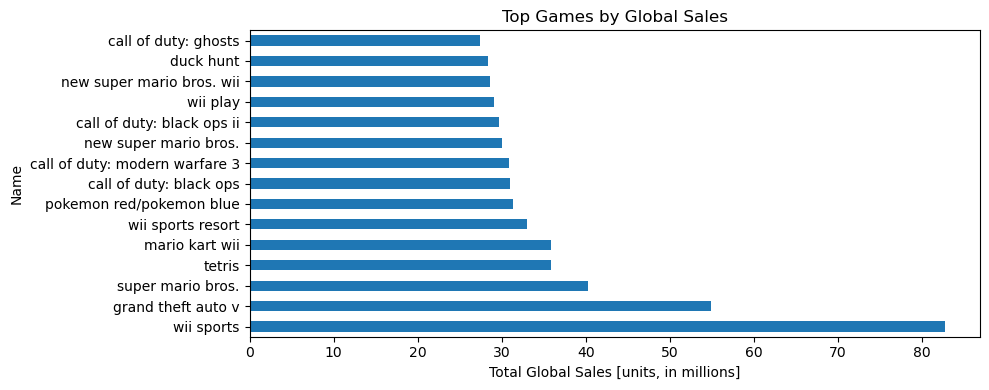

Graph showing top game titles by total global sales.


In [25]:
top_games = vg_df.nlargest(15, 'global_sales').set_index('name')['global_sales']

plt.figure(figsize=(10, 4))
top_games.plot.barh()
plt.xlabel('Total Global Sales [units, in millions]')
plt.ylabel('Name')
plt.title('Top Games by Global Sales')
plt.tight_layout()
plt.savefig("../figures/games_sales.png", dpi=300, bbox_inches="tight")
plt.show()

print("Graph showing top game titles by total global sales.")

### Pipelines

In [26]:
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import root_mean_squared_error, make_scorer

def pipeline_KFold_RMSE(X, y, preprocessor, ML_algo, param_grid, initial_split=0.8, folds=4, verbose=False):
    '''
    This function splits the data to other/test, preprocesses, and runs KFold cross-validation (shuffle on)
    with RMSE as its evaluation and scoring metric.

    Returns 5 test scores with the 5 models that created them.

    PARAMETERS:
    X: feature matrix (unsplit, unpreprocessed)
    y: target variable (unsplit, unpreprocessed)
    preprocessor: a ColumnTransformer to handle preprocessing
    ML_algo: an already initialized ML algorithm to run
    param_grid: hyperparameter grid to tune corresponding to given ML_algo

    initial_split: amount to split into other in the other/test split
    folds: number of folds to split into in KFold
    verbose: flag to print progress and helpful debugging information

    RETURNS:
    test_scores: len(5) array of test scores corresponding to the model in best_models
    best_models: len(5) array of the best model from each random state
    baseline_scores: len(5) array of the baseline scores with that test split
    '''

    test_scores = []
    best_models = []
    baseline_scores = []
    train_scores = []
    val_scores = []

    if verbose:
        print("PARAMETER GRID: ")
        print(param_grid)

    for i in range(5):
        if verbose:
            print("---------------------------")
            print("FOR RANDOM STATE: ", i)
       
        X_other, X_test, y_other, y_test = train_test_split(X, y, train_size=initial_split, random_state=42 + i)
        kf = KFold(n_splits=folds, shuffle=True, random_state=42 + i)
        
        # getting baselines
        avg = np.mean(y_test)
        y_bar = np.full(len(y_test), avg)

        rmse_avg = root_mean_squared_error(y_test, y_bar)
        baseline_scores.append(rmse_avg)

        if verbose:
            print("X_test:")
            print(X_test.shape)
            print("X_other:")
            print(X_other.shape)
            print("------")

        pipe = make_pipeline(preprocessor, ML_algo)

        grid_verbose = 0
        if verbose:
            grid_verbose = 2

        grid = GridSearchCV(pipe, param_grid=param_grid, 
                            scoring=make_scorer(root_mean_squared_error, greater_is_better=False),
                            cv=kf, return_train_score=True, verbose=grid_verbose, n_jobs=-1)
        
        grid.fit(X_other, y_other)

        if verbose:
            print("Best Model Parameters: ", grid.best_params_)
            print("Validation Score: ", grid.best_score_)

        train_scores.append(-grid.cv_results_["mean_train_score"][grid.best_index_])
        val_scores.append(-grid.cv_results_["mean_test_score"][grid.best_index_])

        pred = grid.predict(X_test)

        test_scores.append(root_mean_squared_error(y_test, pred))
        best_models.append(grid)

    return test_scores, best_models, baseline_scores

In [27]:
from sklearn.model_selection import ParameterGrid
import inspect

def pipeline_reduced_feature_sampling(X, y, preprocessor, ML_algo, param_grid, initial_split=0.6, second_split=0.5, verbose=False):
    '''
    This function is almost identical to the above but performs reduced feature sampling and does NOT
    perform KFold splitting. It still uses RMSE for scoring.

    It should be run with a preprocessor that does no imputation.

    It does not return models but does return a test score for each random state.

    NEW PARAMETERS:
    ML_algo: the CLASS of the algorithm to run, not an already initialized algorithm
    second_split: value to split test/val by assuming first split is train/other
    '''

    test_scores = []
    best_models = []
    baseline_scores = []

    if verbose:
        print("PARAMETER GRID: ")
        print(param_grid)

    for i in range(5):
        if verbose:
            print("---------------------------")
            print("FOR RANDOM STATE: ", i)
       
        X_train, X_other, y_train, y_other = train_test_split(X, y, train_size=initial_split, random_state=42 + i)
        X_test, X_val, y_test, y_val = train_test_split(X_other, y_other, train_size=second_split, random_state=42 + i)

        if verbose:
            print("X_train:")
            print(X_train.shape)
            print("X_val:")
            print(X_val.shape)
            print("X_test:")
            print(X_test.shape)
            print("------")

        # getting baselines
        avg = np.mean(y_test)
        y_bar = np.full(len(y_test), avg)

        rmse_avg = root_mean_squared_error(y_test, y_bar)
        baseline_scores.append(rmse_avg)

        X_train_prep_np = preprocessor.fit_transform(X_train)
        X_val_prep_np = preprocessor.transform(X_val)
        X_test_prep_np = preprocessor.transform(X_test)

        feature_names = preprocessor.get_feature_names_out()

        X_train_prep = pd.DataFrame(data=X_train_prep_np,columns=feature_names)
        X_val_prep = pd.DataFrame(data=X_val_prep_np,columns=feature_names)
        X_test_prep = pd.DataFrame(data=X_test_prep_np,columns=feature_names)

        # THE FOLLOWING REDUCED FEATURE SAMPLING ALGO IS FROM CLASS, LECTURE 19, with adjustments:
        # find all unique patterns of missing value in test set
        mask = X_test_prep.isnull()
        unique_rows = np.array(np.unique(mask, axis=0))
        all_y_test_pred = pd.DataFrame()
    
        if verbose:
            print(f"There are f{len(unique_rows)} unique missing value patterns.")
    
        # divide test sets into subgroups according to the unique patterns
        for i in range(len(unique_rows)):
            if verbose:
                print ('Working on unique pattern', i)
                print("------")
            
            # generate X_test subset that matches the unique pattern i
            sub_X_test = pd.DataFrame()
            sub_y_test = pd.Series(dtype=float)
            
            for j in range(len(mask)): # check each row in mask
                row_mask = np.array(mask.iloc[j])
                if np.array_equal(row_mask, unique_rows[i]): # if the pattern matches the ith unique pattern
                    sub_X_test = pd.concat([sub_X_test, X_test_prep.iloc[[j]]]) # append the according X_test row j to the subset
                    sub_y_test = pd.concat([sub_y_test, y_test.iloc[[j]]]) # append the according y_test row j

            sub_X_test = sub_X_test[X_test_prep.columns[~unique_rows[i]]]
            
            # choose the corresponding reduced features for subgroups
            sub_X_train = pd.DataFrame()
            sub_Y_train = pd.DataFrame()
            sub_X_CV = pd.DataFrame()
            sub_y_CV = pd.DataFrame()

            # 1. remove the feature columns that have nans in the corresponding sub_X_test
            sub_X_train = X_train_prep[X_train_prep.columns[~unique_rows[i]]]
            sub_X_CV = X_val_prep[X_val_prep.columns[~unique_rows[i]]]

            # 2.remove the rows in the sub_X_train and sub_X_CV that have any nans
            sub_X_train = sub_X_train.dropna()
            sub_X_CV = sub_X_CV.dropna() 

            # 3.remove the sub_Y_train and sub_y_CV accordingly
            sub_Y_train = y_train.iloc[sub_X_train.index]
            sub_y_CV = y_val.iloc[sub_X_CV.index]

            pg = ParameterGrid(param_grid)

            val_score = np.zeros(len(pg))
            models = []

            for i, params in enumerate(pg):
                sig = inspect.signature(ML_algo.__init__)
                if "random_state" in sig.parameters:
                    clf =  ML_algo(**params, random_state=42 * i)
                else:
                    clf = ML_algo(**params)
                    
                clf.fit(sub_X_train, sub_Y_train)
                models.append(clf) 

                y_val_pred = clf.predict(sub_X_CV)
                val_score[i] = root_mean_squared_error(sub_y_CV, y_val_pred)
            
            if verbose:
                print("Best model parameters: ", np.array(pg)[np.argmax(val_score)])
                print("Corresponding validation score: ", np.max(val_score))
            
            y_test_pred = models[np.argmax(val_score)].predict(sub_X_test)
            y_test_pred_df = pd.DataFrame(y_test_pred[1],columns=['sub_y_test_pred'], index=sub_y_test.index)
            all_y_test_pred = pd.concat([all_y_test_pred, y_test_pred_df])

            best_models.append(models)

        # rank the final y_test_pred according to original y_test index
        all_y_test_pred = all_y_test_pred.sort_index()
        y_test = y_test.sort_index()
                
        # get global RMSE
        total_RMSE = np.sqrt(root_mean_squared_error(y_test, all_y_test_pred))

        test_scores.append(total_RMSE)
        # best_models.append(grid) ??

    return test_scores, best_models, baseline_scores

In [ ]:
import numpy as np
import xgboost
from sklearn.model_selection import train_test_split, ParameterGrid, KFold
from sklearn.metrics import root_mean_squared_error

def pipeline_xgb_model(X, y, preprocessor, param_grid, initial_split=0.8, folds=4, verbose=False):
    '''
    '''
    test_scores = []
    best_models = []
    baseline_scores = []

    pg = list(ParameterGrid(param_grid))

    for rs_idx in range(5):
        if verbose:
            print("---------------------------")
            print("FOR RANDOM STATE:", rs_idx)

        X_other, X_test, y_other, y_test = train_test_split(
            X, y, train_size=initial_split, random_state=42 + rs_idx
        )

        # baseline on test
        y_bar = np.full(len(y_test), np.mean(y_test))
        baseline_scores.append(root_mean_squared_error(y_test, y_bar))

        # CV over X_other
        kf = KFold(n_splits=folds, shuffle=True, random_state=42 + rs_idx)
        mean_rmse_per_param = np.zeros(len(pg), dtype=float)

        for p_idx, params in enumerate(pg):
            fold_rmses = []

            for train_idx, val_idx in kf.split(X_other):
                X_train, X_val = X_other.iloc[train_idx], X_other.iloc[val_idx]
                y_train, y_val = y_other.iloc[train_idx], y_other.iloc[val_idx]

                X_train_p = preprocessor.fit_transform(X_train)
                X_val_p   = preprocessor.transform(X_val)

                model = xgboost.XGBRegressor(
                    n_jobs=-1,
                    tree_method="hist",
                    eval_metric="rmse",
                    n_estimators=100,              
                    early_stopping_rounds=10,
                    random_state=42 + rs_idx,
                    **params
                )

                model.fit(
                    X_train_p, np.asarray(y_train),
                    eval_set=[(X_val_p, np.asarray(y_val))],
                    verbose=False
                )

                pred = model.predict(X_val_p)
                fold_rmses.append(root_mean_squared_error(y_val, pred))

            mean_rmse_per_param[p_idx] = np.mean(fold_rmses)

        best_idx = int(np.argmin(mean_rmse_per_param))
        best_params = pg[best_idx]

        if verbose:
            print("Best CV RMSE:", mean_rmse_per_param[best_idx])
            print("Best params:", best_params)

        # Final fit on ALL X_other, with an internal val split for early stopping
        X_train_full, X_val_full, y_train_full, y_val_full = train_test_split(
            X_other, y_other, test_size=0.2, random_state=123 + rs_idx
        )

        X_train_full_p = preprocessor.fit_transform(X_train_full)
        X_val_full_p   = preprocessor.transform(X_val_full)
        X_test_p       = preprocessor.transform(X_test)

        best_model = xgboost.XGBRegressor(
            n_jobs=-1,
            tree_method="hist",
            eval_metric="rmse",
            n_estimators=100,
            early_stopping_rounds=10,
            random_state=42 + rs_idx,
            **best_params
        )

        best_model.fit(
            X_train_full_p, np.asarray(y_train_full),
            eval_set=[(X_val_full_p, np.asarray(y_val_full))],
            verbose=False
        )

        y_test_pred = best_model.predict(X_test_p)
        test_scores.append(root_mean_squared_error(y_test, y_test_pred))
        best_models.append(best_model)

    return test_scores, best_models, baseline_scores


### Preparing Data for Pipeline

In [29]:
# lists of features
continuous_ftrs = ['score', 'user_score', 'critics', 'users', 'year']
ordinal_ftrs = ['players'] 
ordinal_cats = [['unknown', 'single', 'two', 'multi']]
multi_label = ['developer', 'platform', 'genre', 'publisher']

# split out target variable and logscale it
y = np.log(vg_df['global_sales'])

X = vg_df.loc[:, vg_df.columns != 'global_sales']
X = X.drop('name', axis=1) # drop the name column

# prepping the multi-label features for the binarizer
# making the sets into lists or [] if NaN
for col in multi_label:
    X.loc[:, col] = X[col].apply(lambda x: [] if pd.isna(x) else list(x))

print(X.head())
print(y.head())

    publisher   developer players  score  user_score  critics  users platform  \
0  [nintendo]  [Nintendo]  single   76.0         8.0     51.0  429.0    [Wii]   
1  [nintendo]          []     NaN    NaN         NaN      NaN    NaN    [NES]   
2  [nintendo]  [Nintendo]   multi   82.0         8.4     73.0  982.0    [Wii]   
3  [nintendo]  [Nintendo]   multi   80.0         8.1     73.0  266.0    [Wii]   
4  [nintendo]          []     NaN    NaN         NaN      NaN    NaN     [GB]   

                                         genre  year  
0     [Individual, Athletics, General, Sports]  2006  
1                                   [Platform]  1985  
2  [Racing, Automobile, Arcade, Kart, Driving]  2008  
3     [Individual, Athletics, General, Sports]  2009  
4                               [Role-Playing]  1996  
0    4.415703
1    3.694862
2    3.578506
3    3.496508
4    3.445852
Name: global_sales, dtype: float64


### Preparing Preprocessors

In [30]:
# CODE FOR A CUSTOM MULTILABEL BINARIZER TRANSFORMER
# sklearn's MultiLabelBinarizer does not natively work with the ColumnTransformer.
# In order to make my pipeline as extendable and reliable as possible, I found 
# the following code from StackOverflow to turn the processor into a transformer that can be put
# into a greater pipeline.

# Source - https://stackoverflow.com/questions/59254662/sklearn-columntransformer-with-multilabelbinarizer
# Posted by ji.xu, modified by community. See post 'Timeline' for change history
# Retrieved 2025-12-08, License - CC BY-SA 4.0

# Source - https://stackoverflow.com/questions/59254662/sklearn-columntransformer-with-multilabelbinarizer
# Posted by Adib
# Retrieved 2025-12-11, License - CC BY-SA 4.0
# Used for the get_feature_names_out() function

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MultiLabelBinarizer
import warnings

class MultiHotEncoder(BaseEstimator, TransformerMixin):
    """Wraps `MultiLabelBinarizer` in a form that can work with `ColumnTransformer`. Note
    that input X has to be a `pandas.DataFrame`.
    """
    def __init__(self):
        self.mlbs = list()
        self.n_columns = 0
        self.categories_ = self.classes_ = list()

    def fit(self, X:pd.DataFrame, y=None):
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message=r"unknown class\(es\).*will be ignored",
                category=UserWarning
            )
            
        for i in range(X.shape[1]): # X can be of multiple columns
            mlb = MultiLabelBinarizer()
            mlb.fit(X.iloc[:,i])
            self.mlbs.append(mlb)
            self.classes_.append(mlb.classes_)
            self.n_columns += 1
        return self

    def transform(self, X:pd.DataFrame):
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message=r"unknown class\(es\).*will be ignored",
                category=UserWarning
            )

        if self.n_columns == 0:
            raise ValueError('Please fit the transformer first.')
        if self.n_columns != X.shape[1]:
            raise ValueError(f'The fit transformer deals with {self.n_columns} columns '
                             f'while the input has {X.shape[1]}.'
                            )
        result = list()
        for i in range(self.n_columns):
            result.append(self.mlbs[i].transform(X.iloc[:,i]))

        result = np.concatenate(result, axis=1)
        return result
        
    def get_feature_names_out(self, input_features=None):
        cats = self.categories_
        if input_features is None:
            input_features = self.columns
        elif len(input_features) != len(self.categories_):
            raise ValueError(
                "input_features should have length equal to number of "
                "features ({}), got {}".format(len(self.categories_),
                                               len(input_features)))

        feature_names = []
        for i in range(len(cats)):
            names = [input_features[i] + "_" + str(t) for t in cats[i]]
            feature_names.extend(names)

        return np.asarray(feature_names, dtype=object)

In [31]:
# Source - https://stackoverflow.com/a
# Posted by mcapizzi
# Retrieved 2025-12-11, License - CC BY-SA 4.0

class MultiLabelBinarizerFixedTransformer(BaseEstimator, TransformerMixin):
    """       
    Wraps `MultiLabelBinarizer` in a form that can work with `ColumnTransformer`
    """
    def __init__(
            self 
        ):
        self.feature_name = ["mlb"]
        self.mlb = MultiLabelBinarizer(sparse_output=False)

    def fit(self, X, y=None):
        self.mlb.fit(X)
        return self

    def transform(self, X):
        return self.mlb.transform(X)

    def get_feature_names(self, input_features=None):
        cats = self.mlb.classes_
        if input_features is None:
            input_features = ['x%d' % i for i in range(len(cats))]
            print(input_features)
        elif len(input_features) != len(self.categories_):
            raise ValueError(
                "input_features should have length equal to number of "
                "features ({}), got {}".format(len(self.categories_),
                                               len(input_features)))

        feature_names = [f"{input_features[i]}_{cats[i]}" for i in range(len(cats))]
        return np.array(feature_names, dtype=object)


In [32]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder

# ordinal transformer used in all preprocessing pipelines
ordinal_transformer = Pipeline(steps=[
    ('imputer_ord', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('ordinal', OrdinalEncoder(categories=ordinal_cats))]
)

# general preprocessing pipeline will be:
# standard scaling on continuous features, ordinal encoding for players, then multi-hot for specific columns

In [33]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

# preprocessor pipeline with imputing: 
imputing_numeric_transformer = Pipeline(steps=[
    ('imputer_cont', IterativeImputer(estimator=RandomForestRegressor(n_estimators=1, random_state=42))),
    ('standard', StandardScaler())
])

imputing_preprocessor = ColumnTransformer(
    transformers=[
        ('std', imputing_numeric_transformer, continuous_ftrs),
        ('ord', ordinal_transformer, ordinal_ftrs),
        ('multi-hot', MultiHotEncoder(), multi_label)
    ])

In [34]:
# preprocessor pipeline with no imputation
# used for XGBoost and for reduced feature sampling
basic_preprocessor = ColumnTransformer(
    transformers=[
        ('std', StandardScaler(), continuous_ftrs),
        ('ord', ordinal_transformer, ordinal_ftrs),
        ('multi-hot', MultiHotEncoder(), multi_label)
    ])

### Training Models

#### Random Forest:

In [35]:
param_grid_rf = {
    "randomforestregressor__max_depth": [3, 7, 10, 15],
    "randomforestregressor__max_features": ["sqrt", "log2"]
}
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
test_scores_rf, best_models_rf, baselines_rf = pipeline_KFold_RMSE(X, y, basic_preprocessor, rf, param_grid_rf)

/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['2DBoy', '369Interactive', '3d6Games', '8MonkeyLabs', 'Adrenium', 'Agenda', 'AquaPacific', 'Artdink', 'BattleGoatStudios', 'Bec', 'BigPark', 'BlackLanternStudios', 'BlackSeaStudios', 'BlueFangGames', 'BluePlanetSoftware', 'BossGameStudios', 'BreakthroughNewMedia', 'BroadswordInteractive', 'BrownieBrown', 'CUBETYPE', 'Camouflaj', 'CerasusMedia', 'CertainAffinity', 'ChunSoft', 'CiRCLE', 'Cinemaware', 'CircusFreak', 'CodoGames', 'ComputerArtworks', 'CrypticStudios', 'DeepSpace', 'DesertProductions', 'DigitalFiction', 'DingoInc.', 'DoubleEleven', 'DreamCatcherInteractive', 'EAChicago', 'EAPhenomic', 'EASportsBig', 'Egosoft', 'EidosMontreal', 'FUNLabs', 'FallLineStudio', 'FarsightTechnologies', 'FeelPlus', 'Funatics', 'FunaticsSoftware', 'G1M2', 'GameCo', 'Gameinvest', 'GamenessArtSoftware', 'GamesFarm', 'GamingMindsStudios', 'GuildfordStudio', 'Gulti', 'H2OInteract

KeyboardInterrupt: 

In [ ]:
print("------------------")
print("For Random Forest:")
print("Test mean RMSE: ", np.mean(test_scores_rf))
print("Test RMSE std. dev.: ", np.std(test_scores_rf))
print("Baseline mean RMSE: ", np.mean(baselines_rf))

best_rf = best_models_rf[np.argmax(test_scores_rf)]
print("Best hyperparameters: ", best_rf.best_estimator_.named_steps["randomforestregressor"])

------------------
For Random Forest:
Test mean RMSE:  1.2638287743925851
Test RMSE std. dev.:  0.015890117266249865
Baseline mean RMSE:  1.6055017996610559
Best hyperparameters:  RandomForestRegressor(max_depth=15, max_features='sqrt', n_jobs=-1,
                      random_state=42)


#### Ridge Regression (with imputation)

In [ ]:
from  sklearn.linear_model import Ridge

param_grid_ridge = {
    "ridge__alpha": np.logspace(-2, 2, 5)
}
ridge = Ridge(max_iter=int(1e6))
test_ridge, models_ridge, baselines_ridge = pipeline_KFold_RMSE(X, y, imputing_preprocessor, ridge, param_grid_ridge)

/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/impu

In [ ]:
print("------------------")
print("For Ridge regression, imputation:")
print("Test mean RMSE: ", np.mean(test_ridge))
print("Test RMSE std. dev.: ", np.std(test_ridge))
print("Baseline mean RMSE: ", np.mean(baselines_ridge))

best_ridge = models_ridge[np.argmax(test_ridge)]
print("Best hyperparameters: ", best_ridge.best_estimator_.named_steps["ridge"])

------------------
For Ridge regression, imputation:
Test mean RMSE:  1.0793882308758729
Test RMSE std. dev.:  0.021145591603959197
Baseline mean RMSE:  1.6055017996610559
Best hyperparameters:  Ridge(alpha=np.float64(10.0), max_iter=1000000)


#### Ridge Regression (with reduced feature sampling)

In [ ]:
param_grid_ridge_rfs = {
    "alpha": np.logspace(-2, 2, 5)
}
test_ridge_rfs, models_ridge_rfs, baselines_ridge_rfs = pipeline_reduced_feature_sampling(X, y, basic_preprocessor, Ridge, param_grid_ridge_rfs)

/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['10tacleStudios', 'AbstractionGames', 'AcclaimStudiosManchester', 'AdelineSoftware', 'Agenda', 'AlphaUnit', 'AndamiroU.S.A.Corp.', 'AnimationArts', 'AppaloosaInteractive', 'Artdink', 'ArtefactsStudio', 'AsmikAceEntertainment', 'AwesomePlayLtd.', 'Banpresto', 'BattleGoatStudios', 'BethesdaSoftworks', 'BigBlueBox', 'BigTimeSoftware', 'BitTown', 'BottleRocketEntertainment', 'BreakthroughNewMedia', 'BuenaVistaInteractive', 'CUBETYPE', 'Camouflaj', 'CapcomVancouver', 'CertainAffinity', 'ChrisSawyer', 'ClockworkGames', 'ContrabandEntertainment', 'CreatureLabs', 'DREAMONSTUDIO', 'DeadlineGames', 'DigitalEmbryo', 'DinoDini', 'Dracue', 'DreamCatcherInteractive', 'EAPhenomic', 'EASaltLake', 'Eidetic', 'EidosMontreal', 'EnjoyUpGames', 'Europress', 'FUNLabs', 'FatsharkAB', 'FlagshipStudios', 'Flight-Plan', 'Foundation9Entertainment', 'Funatics', 'FunaticsSoftware', 'GameLa

In [ ]:
print("------------------")
print("For Ridge regression, reduced feature sampling:")
print("Test mean RMSE: ", np.mean(test_ridge_rfs))
print("Test RMSE std. dev.: ", np.std(test_ridge_rfs))
print("Baseline mean RMSE: ", np.mean(baselines_ridge_rfs))

------------------
For Ridge regression, reduced feature sampling:
Test mean RMSE:  1.385880943784517
Test RMSE std. dev.:  0.13800982963884842
Baseline mean RMSE:  1.6040202608664977


#### K-Nearest Neighbors (with imputation)

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

param_grid_kneighbors= {
    "kneighborsregressor__n_neighbors": list(range(1, 21, 3))
}
kneighbors = KNeighborsRegressor()
test_KNN, models_KNN, baseline_KNN = pipeline_KFold_RMSE(X, y, imputing_preprocessor, kneighbors, param_grid_kneighbors)

/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/impu

In [ ]:
print("------------------")
print("For K Nearest Neighbors, imputed:")
print("Test mean RMSE: ", np.mean(test_KNN))
print("Test RMSE std. dev.: ", np.std(test_KNN))
print("Baseline mean RMSE: ", np.mean(baseline_KNN))

best_knn = models_KNN[np.argmax(test_KNN)]
print("Best hyperparameters: ", best_knn.best_estimator_.named_steps["kneighborsregressor"])

------------------
For K Nearest Neighbors, imputed:
Test mean RMSE:  1.1850488003401842
Test RMSE std. dev.:  0.01982961647441283
Baseline mean RMSE:  1.6055017996610559
Best hyperparameters:  KNeighborsRegressor(n_neighbors=7)


#### K-Nearest Neighbors (with  reduced feature sampling)

In [ ]:
param_grid_kneighbor_rfs= {
    "n_neighbors": list(range(1, 21, 3))
}
test_KNN_rfs, models_KNN_rfs, baseline_KNN_rfs = pipeline_reduced_feature_sampling(X, y, basic_preprocessor, KNeighborsRegressor, param_grid_kneighbor_rfs)

/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['10tacleStudios', 'AbstractionGames', 'AcclaimStudiosManchester', 'AdelineSoftware', 'Agenda', 'AlphaUnit', 'AndamiroU.S.A.Corp.', 'AnimationArts', 'AppaloosaInteractive', 'Artdink', 'ArtefactsStudio', 'AsmikAceEntertainment', 'AwesomePlayLtd.', 'Banpresto', 'BattleGoatStudios', 'BethesdaSoftworks', 'BigBlueBox', 'BigTimeSoftware', 'BitTown', 'BottleRocketEntertainment', 'BreakthroughNewMedia', 'BuenaVistaInteractive', 'CUBETYPE', 'Camouflaj', 'CapcomVancouver', 'CertainAffinity', 'ChrisSawyer', 'ClockworkGames', 'ContrabandEntertainment', 'CreatureLabs', 'DREAMONSTUDIO', 'DeadlineGames', 'DigitalEmbryo', 'DinoDini', 'Dracue', 'DreamCatcherInteractive', 'EAPhenomic', 'EASaltLake', 'Eidetic', 'EidosMontreal', 'EnjoyUpGames', 'Europress', 'FUNLabs', 'FatsharkAB', 'FlagshipStudios', 'Flight-Plan', 'Foundation9Entertainment', 'Funatics', 'FunaticsSoftware', 'GameLa

In [ ]:
print("------------------")
print("For K Nearest Neighbors, rfs:")
print("Test mean RMSE: ", np.mean(test_KNN_rfs))
print("Test RMSE std. dev.: ", np.std(test_KNN_rfs))
print("Baseline mean RMSE: ", np.mean(baseline_KNN_rfs))

------------------
For K Nearest Neighbors, rfs:
Test mean RMSE:  1.6848138261293368
Test RMSE std. dev.:  0.3457157067780376
Baseline mean RMSE:  1.6040202608664977


#### XGBoost

In [ ]:
param_grid_xgb = {
    "learning_rate": [0.03],
    "max_depth": [3, 5],           
    "subsample": [0.66],
    "colsample_bytree": [0.8],   
}
test_XGB, models_XGB, baseline_XGB = pipeline_xgb_model(X, y, basic_preprocessor, param_grid_xgb)

/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['2DBoy', '369Interactive', '3d6Games', '4JStudios', '8MonkeyLabs', 'ActivisionValue', 'Adrenium', 'Agenda', 'AksysGames', 'AquaPacific', 'Artdink', 'ArtificialStudios', 'Aspect', 'BattleGoatStudios', 'Bec', 'BelugaComputer', 'BigPark', 'BlackLanternStudios', 'BlackSeaStudios', 'BlueFangGames', 'BluePlanetSoftware', 'Bongfish', 'BossGameStudios', 'BreakthroughNewMedia', 'BroadswordInteractive', 'BrownieBrown', 'CUBETYPE', 'Camouflaj', 'CarbineStudios', 'CatDaddyGames', 'CerasusMedia', 'CertainAffinity', 'Chime', 'ChunSoft', 'CiRCLE', 'Cinemaware', 'CircusFreak', 'CodoGames', 'ComputerArtworks', 'CreaturesInc.', 'CrypticStudios', 'DeepSpace', 'DesertProductions', 'DevilsDetails', 'DigitalEmbryo', 'DigitalFiction', 'DingoInc.', 'DoubleEleven', 'DreamCatcherInteractive', 'EAChicago', 'EAPhenomic', 'EASportsBig', 'Egosoft', 'EidosMontreal', 'EngineSoftware', 'FUNLab

In [48]:
print("------------------")
print("For XGBoost:")
print("Test mean RMSE: ", np.mean(test_XGB))
print("Test RMSE std. dev.: ", np.std(test_XGB))
print("Baseline mean RMSE: ", np.mean(baseline_XGB))

best_XGB = models_XGB[np.argmax(test_XGB)]

print("Best parameters: ")
for k, v in best_XGB.get_params().items():
    if v is not None:
        print(f"{k}: {v}")

------------------
For XGBoost:
Test mean RMSE:  1.1016836390502192
Test RMSE std. dev.:  0.015074936615213584
Baseline mean RMSE:  1.6055017996610559
Best parameters: 
objective: reg:squarederror
colsample_bytree: 0.8
early_stopping_rounds: 25
enable_categorical: False
eval_metric: rmse
learning_rate: 0.03
max_depth: 6
missing: nan
n_estimators: 100
n_jobs: -1
random_state: 43
subsample: 0.66
tree_method: hist
seed: 42


### Summarizing Results

In [ ]:
all_baselines = np.array([baselines_rf, baselines_ridge, baseline_KNN, baseline_KNN_rfs, baselines_ridge_rfs, baseline_XGB])
avg_baseline = np.mean(all_baselines)
stddev_baseline = np.std(all_baselines)

print("OVERALL BASELINE: ", avg_baseline)
print("OVERALL STDDEV: ", stddev_baseline)

OVERALL BASELINE:  1.6050079533962034
OVERALL STDDEV:  0.010339979229616639


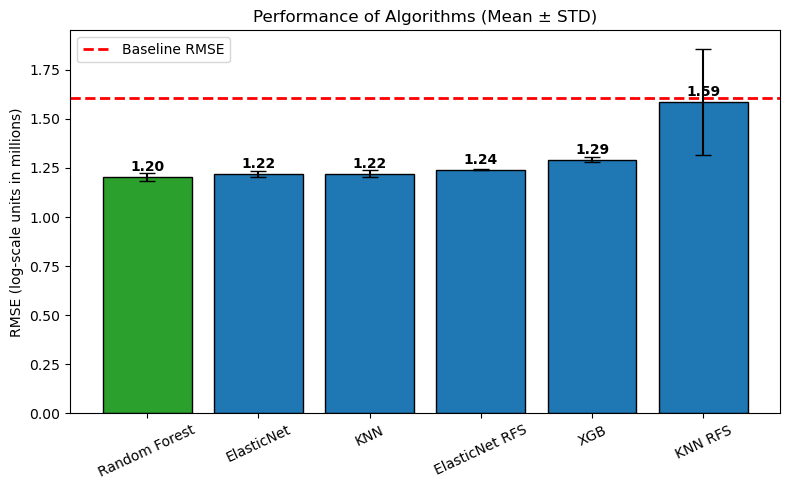

In [ ]:
avg_scores = np.array([np.mean(test_scores_rf), np.mean(test_ridge), np.mean(test_ridge_rfs), np.mean(test_KNN), np.mean(test_KNN_rfs), np.mean(test_XGB)])
stddev_scores = np.array([np.std(test_scores_rf), np.std(test_ridge), np.std(test_ridge_rfs), np.std(test_KNN), np.std(test_KNN_rfs), np.std(test_XGB)])
names = np.array(["Random Forest", "ElasticNet", "ElasticNet RFS", "KNN", "KNN RFS", "XGB"])

plt.figure(figsize=(8, 5))

sorted_idx = np.argsort(avg_scores)
names_sorted = [names[i] for i in sorted_idx]
avg_sorted = [avg_scores[i] for i in sorted_idx]
std_sorted = [stddev_scores[i] for i in sorted_idx]

colors = ['#1f77b4'] * len(avg_sorted)
colors[0] = '#2ca02c'

plt.axhline(avg_baseline, color='red', linestyle='--', linewidth=2, label="Baseline RMSE")

plt.bar(names_sorted, avg_sorted, yerr=std_sorted, color=colors, edgecolor="black", linewidth=1, capsize=6)

for i, v in enumerate(avg_sorted):
    plt.text(i, v + 0.03, f"{v:.2f}", ha='center', fontweight='bold')

plt.ylabel("RMSE (log-scale units in millions)")
plt.title("Performance of Algorithms (Mean ± STD)")
plt.xticks(rotation=25)
plt.legend()
plt.tight_layout()
plt.savefig("../figures/performance.png", dpi=300, bbox_inches="tight")
plt.show()

### Interpretation

In [ ]:
np.random.seed(42)

X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_other, y_other, test_size=0.25, random_state=0)

ftr_names = X_test.columns
nr_runs = 10
scores = np.zeros([len(ftr_names),nr_runs])

best_model = best_models_rf[np.argmax(test_scores_rf)]

test_rmse = root_mean_squared_error(y_test, best_model.predict(X_test))

df_test = pd.DataFrame(data=X_test, columns=ftr_names)



In [ ]:
np.random.seed(42)

X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_other, y_other, test_size=0.25, random_state=0)

ftr_names = X_test.columns
nr_runs = 10
scores = np.zeros([len(ftr_names),nr_runs])

best_model = best_models_rf[np.argmax(test_scores_rf)]

test_rmse = root_mean_squared_error(y_test, best_model.predict(X_test))

df_test = pd.DataFrame(data=X_test, columns=ftr_names)

for i in range(len(ftr_names)):
    print("Shuffling " + str(ftr_names[i]))
    neg_RMSEs = []
    for j in range(nr_runs):
        df_test_shuffled = X_test.copy()
        df_test_shuffled[ftr_names[i]] = np.random.permutation(df_test[ftr_names[i]].values)
        pred = best_model.predict(df_test_shuffled)
        neg_RMSEs.append(np.abs(test_rmse - root_mean_squared_error(y_test, pred)))
    print('   shuffled test score:',np.around(np.mean(neg_RMSEs),3),'+/-',np.around(np.std(neg_RMSEs),3))
    scores[i] = neg_RMSEs

/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['ArtCo.', 'Aspect', 'BostonAnimation', 'CodoGames', 'ConspiracyEntertainment', 'CunningDevelopments', 'DavidA.PalmerProductions', 'EngineSoftware', 'FlyingLabSoftware', 'GCP1', 'H2OInteractive', 'InfiniteDreams', 'KodiakInteractive', 'KonamiSoftwareShanghai', 'MASAGroup', 'MetanetSoftwareInc.', 'Paragon5', 'PiranhaGames', 'Robomodo', 'SCSSoftware', 'SilverBirchStudios', 'SlickEntertainment', 'StillAliveStudios', 'Stormregion', 'Tiwak', 'UbisoftBulgaria', 'UbisoftShanghai/Paris'] will be ignored
  warnings.warn(
/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['Skating'] will be ignored
  warnings.warn(
/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['activision blizzard', 'cbs electronics', 'magical company

Shuffling publisher


/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['ArtCo.', 'Aspect', 'BostonAnimation', 'CodoGames', 'ConspiracyEntertainment', 'CunningDevelopments', 'DavidA.PalmerProductions', 'EngineSoftware', 'FlyingLabSoftware', 'GCP1', 'H2OInteractive', 'InfiniteDreams', 'KodiakInteractive', 'KonamiSoftwareShanghai', 'MASAGroup', 'MetanetSoftwareInc.', 'Paragon5', 'PiranhaGames', 'Robomodo', 'SCSSoftware', 'SilverBirchStudios', 'SlickEntertainment', 'StillAliveStudios', 'Stormregion', 'Tiwak', 'UbisoftBulgaria', 'UbisoftShanghai/Paris'] will be ignored
  warnings.warn(
/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['Skating'] will be ignored
  warnings.warn(
/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['activision blizzard', 'cbs electronics', 'magical company

   shuffled test score: 0.182 +/- 0.007
Shuffling developer


/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['ArtCo.', 'Aspect', 'BostonAnimation', 'CodoGames', 'ConspiracyEntertainment', 'CunningDevelopments', 'DavidA.PalmerProductions', 'EngineSoftware', 'FlyingLabSoftware', 'GCP1', 'H2OInteractive', 'InfiniteDreams', 'KodiakInteractive', 'KonamiSoftwareShanghai', 'MASAGroup', 'MetanetSoftwareInc.', 'Paragon5', 'PiranhaGames', 'Robomodo', 'SCSSoftware', 'SilverBirchStudios', 'SlickEntertainment', 'StillAliveStudios', 'Stormregion', 'Tiwak', 'UbisoftBulgaria', 'UbisoftShanghai/Paris'] will be ignored
  warnings.warn(
/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['Skating'] will be ignored
  warnings.warn(
/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['activision blizzard', 'cbs electronics', 'magical company

   shuffled test score: 0.031 +/- 0.001
Shuffling players


/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['ArtCo.', 'Aspect', 'BostonAnimation', 'CodoGames', 'ConspiracyEntertainment', 'CunningDevelopments', 'DavidA.PalmerProductions', 'EngineSoftware', 'FlyingLabSoftware', 'GCP1', 'H2OInteractive', 'InfiniteDreams', 'KodiakInteractive', 'KonamiSoftwareShanghai', 'MASAGroup', 'MetanetSoftwareInc.', 'Paragon5', 'PiranhaGames', 'Robomodo', 'SCSSoftware', 'SilverBirchStudios', 'SlickEntertainment', 'StillAliveStudios', 'Stormregion', 'Tiwak', 'UbisoftBulgaria', 'UbisoftShanghai/Paris'] will be ignored
  warnings.warn(
/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['Skating'] will be ignored
  warnings.warn(
/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['activision blizzard', 'cbs electronics', 'magical company

   shuffled test score: 0.02 +/- 0.001
Shuffling score


/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['ArtCo.', 'Aspect', 'BostonAnimation', 'CodoGames', 'ConspiracyEntertainment', 'CunningDevelopments', 'DavidA.PalmerProductions', 'EngineSoftware', 'FlyingLabSoftware', 'GCP1', 'H2OInteractive', 'InfiniteDreams', 'KodiakInteractive', 'KonamiSoftwareShanghai', 'MASAGroup', 'MetanetSoftwareInc.', 'Paragon5', 'PiranhaGames', 'Robomodo', 'SCSSoftware', 'SilverBirchStudios', 'SlickEntertainment', 'StillAliveStudios', 'Stormregion', 'Tiwak', 'UbisoftBulgaria', 'UbisoftShanghai/Paris'] will be ignored
  warnings.warn(
/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['Skating'] will be ignored
  warnings.warn(
/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['activision blizzard', 'cbs electronics', 'magical company

   shuffled test score: 0.03 +/- 0.001
Shuffling user_score


/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['ArtCo.', 'Aspect', 'BostonAnimation', 'CodoGames', 'ConspiracyEntertainment', 'CunningDevelopments', 'DavidA.PalmerProductions', 'EngineSoftware', 'FlyingLabSoftware', 'GCP1', 'H2OInteractive', 'InfiniteDreams', 'KodiakInteractive', 'KonamiSoftwareShanghai', 'MASAGroup', 'MetanetSoftwareInc.', 'Paragon5', 'PiranhaGames', 'Robomodo', 'SCSSoftware', 'SilverBirchStudios', 'SlickEntertainment', 'StillAliveStudios', 'Stormregion', 'Tiwak', 'UbisoftBulgaria', 'UbisoftShanghai/Paris'] will be ignored
  warnings.warn(
/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['Skating'] will be ignored
  warnings.warn(
/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['activision blizzard', 'cbs electronics', 'magical company

   shuffled test score: 0.043 +/- 0.002
Shuffling critics


/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['ArtCo.', 'Aspect', 'BostonAnimation', 'CodoGames', 'ConspiracyEntertainment', 'CunningDevelopments', 'DavidA.PalmerProductions', 'EngineSoftware', 'FlyingLabSoftware', 'GCP1', 'H2OInteractive', 'InfiniteDreams', 'KodiakInteractive', 'KonamiSoftwareShanghai', 'MASAGroup', 'MetanetSoftwareInc.', 'Paragon5', 'PiranhaGames', 'Robomodo', 'SCSSoftware', 'SilverBirchStudios', 'SlickEntertainment', 'StillAliveStudios', 'Stormregion', 'Tiwak', 'UbisoftBulgaria', 'UbisoftShanghai/Paris'] will be ignored
  warnings.warn(
/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['Skating'] will be ignored
  warnings.warn(
/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['activision blizzard', 'cbs electronics', 'magical company

   shuffled test score: 0.041 +/- 0.002
Shuffling users


/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['ArtCo.', 'Aspect', 'BostonAnimation', 'CodoGames', 'ConspiracyEntertainment', 'CunningDevelopments', 'DavidA.PalmerProductions', 'EngineSoftware', 'FlyingLabSoftware', 'GCP1', 'H2OInteractive', 'InfiniteDreams', 'KodiakInteractive', 'KonamiSoftwareShanghai', 'MASAGroup', 'MetanetSoftwareInc.', 'Paragon5', 'PiranhaGames', 'Robomodo', 'SCSSoftware', 'SilverBirchStudios', 'SlickEntertainment', 'StillAliveStudios', 'Stormregion', 'Tiwak', 'UbisoftBulgaria', 'UbisoftShanghai/Paris'] will be ignored
  warnings.warn(
/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['Skating'] will be ignored
  warnings.warn(
/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['activision blizzard', 'cbs electronics', 'magical company

   shuffled test score: 0.062 +/- 0.002
Shuffling platform


/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['ArtCo.', 'Aspect', 'BostonAnimation', 'CodoGames', 'ConspiracyEntertainment', 'CunningDevelopments', 'DavidA.PalmerProductions', 'EngineSoftware', 'FlyingLabSoftware', 'GCP1', 'H2OInteractive', 'InfiniteDreams', 'KodiakInteractive', 'KonamiSoftwareShanghai', 'MASAGroup', 'MetanetSoftwareInc.', 'Paragon5', 'PiranhaGames', 'Robomodo', 'SCSSoftware', 'SilverBirchStudios', 'SlickEntertainment', 'StillAliveStudios', 'Stormregion', 'Tiwak', 'UbisoftBulgaria', 'UbisoftShanghai/Paris'] will be ignored
  warnings.warn(
/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['Skating'] will be ignored
  warnings.warn(
/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['activision blizzard', 'cbs electronics', 'magical company

   shuffled test score: 0.156 +/- 0.007
Shuffling genre


/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['ArtCo.', 'Aspect', 'BostonAnimation', 'CodoGames', 'ConspiracyEntertainment', 'CunningDevelopments', 'DavidA.PalmerProductions', 'EngineSoftware', 'FlyingLabSoftware', 'GCP1', 'H2OInteractive', 'InfiniteDreams', 'KodiakInteractive', 'KonamiSoftwareShanghai', 'MASAGroup', 'MetanetSoftwareInc.', 'Paragon5', 'PiranhaGames', 'Robomodo', 'SCSSoftware', 'SilverBirchStudios', 'SlickEntertainment', 'StillAliveStudios', 'Stormregion', 'Tiwak', 'UbisoftBulgaria', 'UbisoftShanghai/Paris'] will be ignored
  warnings.warn(
/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['Skating'] will be ignored
  warnings.warn(
/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['activision blizzard', 'cbs electronics', 'magical company

   shuffled test score: 0.118 +/- 0.003
Shuffling year


/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['ArtCo.', 'Aspect', 'BostonAnimation', 'CodoGames', 'ConspiracyEntertainment', 'CunningDevelopments', 'DavidA.PalmerProductions', 'EngineSoftware', 'FlyingLabSoftware', 'GCP1', 'H2OInteractive', 'InfiniteDreams', 'KodiakInteractive', 'KonamiSoftwareShanghai', 'MASAGroup', 'MetanetSoftwareInc.', 'Paragon5', 'PiranhaGames', 'Robomodo', 'SCSSoftware', 'SilverBirchStudios', 'SlickEntertainment', 'StillAliveStudios', 'Stormregion', 'Tiwak', 'UbisoftBulgaria', 'UbisoftShanghai/Paris'] will be ignored
  warnings.warn(
/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['Skating'] will be ignored
  warnings.warn(
/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['activision blizzard', 'cbs electronics', 'magical company

   shuffled test score: 0.035 +/- 0.001


/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['ArtCo.', 'Aspect', 'BostonAnimation', 'CodoGames', 'ConspiracyEntertainment', 'CunningDevelopments', 'DavidA.PalmerProductions', 'EngineSoftware', 'FlyingLabSoftware', 'GCP1', 'H2OInteractive', 'InfiniteDreams', 'KodiakInteractive', 'KonamiSoftwareShanghai', 'MASAGroup', 'MetanetSoftwareInc.', 'Paragon5', 'PiranhaGames', 'Robomodo', 'SCSSoftware', 'SilverBirchStudios', 'SlickEntertainment', 'StillAliveStudios', 'Stormregion', 'Tiwak', 'UbisoftBulgaria', 'UbisoftShanghai/Paris'] will be ignored
  warnings.warn(
/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['Skating'] will be ignored
  warnings.warn(
/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['activision blizzard', 'cbs electronics', 'magical company

/var/folders/v8/_jhww54x34gg2zggklfkh9tr0000gn/T/ipykernel_4780/4123018050.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


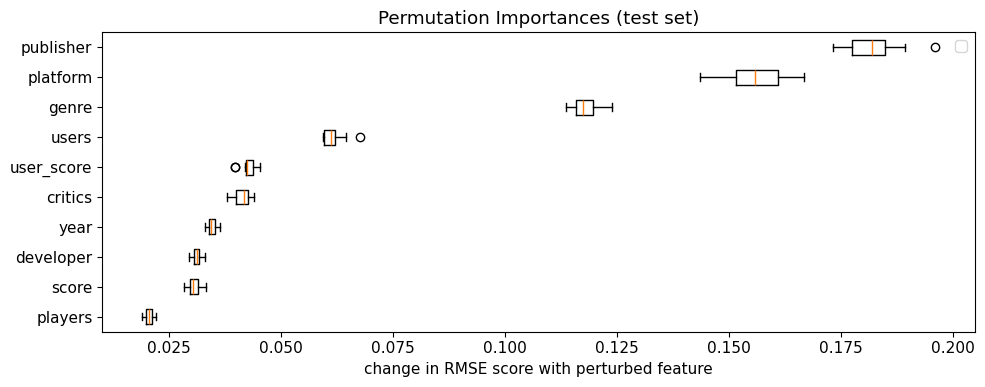

publisher: 0.1823490880959995 +/- 0.006646650971581541
platform: 0.1557829484747698 +/- 0.007040588327322695
genre: 0.11814530019316308 +/- 0.003042794388167196
users: 0.061659025772958606 +/- 0.0024634153034884592
user_score: 0.0425826904440727 +/- 0.001850550010393033
critics: 0.04122536869247491 +/- 0.0019103588777509763
year: 0.03457666356824285 +/- 0.0010245661992806206
developer: 0.031139321567465884 +/- 0.0010685173205355952
score: 0.030497224602248442 +/- 0.0013875459275400981
players: 0.02044270402862214 +/- 0.0009825007325512485


In [ ]:
sorted_indcs = np.argsort(np.mean(scores,axis=1))[::-1][:10][::-1]
plt.rcParams.update({'font.size': 11})
plt.figure(figsize=(10, 4))
plt.boxplot(scores[sorted_indcs].T,tick_labels=ftr_names[sorted_indcs],vert=False)
plt.title("Permutation Importances (test set)")
plt.xlabel('change in RMSE score with perturbed feature')
plt.tight_layout()
plt.savefig("../figures/permutation_importances.png", dpi=300, bbox_inches="tight")
plt.show()

top_score_mean = np.mean(scores[sorted_indcs], axis=1)[::-1]
top_score_stddev = np.std(scores[sorted_indcs], axis=1)[::-1]
top_ftrs = ftr_names[sorted_indcs][::-1]

for mean, stddev, ftr in zip(top_score_mean, top_score_stddev, top_ftrs):
    print(f"{ftr}: {mean} +/- {stddev}")

In [ ]:
# your code here
import shap
shap.initjs()


preprocessor = best_model.best_estimator_.named_steps["columntransformer"]
X_test_prep = preprocessor.transform(X_test)

ftr_names_prep = preprocessor.get_feature_names_out()

df_test_prep = pd.DataFrame(data=X_test_prep, columns=ftr_names_prep)

explainer = shap.TreeExplainer(best_model.best_estimator_.named_steps["randomforestregressor"])
shap_values = explainer.shap_values(df_test_prep[:1000])
shap.summary_plot(shap_values, df_test_prep[:1000], feature_names=ftr_names_prep, max_display=10)

shap_avgs = np.mean(np.abs(shap_values), axis=0)
top10 = np.argsort(shap_avgs)[-10:][::-1]

for idx in top10:
    print(f"{ftr_names_prep[idx]}: {shap_avgs[idx]}")

NameError: name 'best_model' is not defined